# Importation des packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm



# Importation des données

In [2]:
# Vérifier le répertoire courant
current_directory = os.getcwd()


# Chemin relatif vers le fichier dans le sous-dossier
file_path1 = os.path.join(current_directory,'..', 'Data', 'X_train_test_pro.csv')
#file_y_test = os.path.join(current_directory,'..', 'Data', 'y_test_pro.csv')
#file_x_test = os.path.join(current_directory,'..', 'Data', 'X_test_pro.csv')

# Charger le fichier CSV
df = pd.read_csv(file_path1, sep=';')
#X_test = pd.read_csv(file_x_test)
#y_test= pd.read_csv(file_y_test)

# Afficher les premières lignes des fichier
print(df.head())

     Id  GarageType  GarageFinish  GarageCars  GarageArea  GarageQual  \
0   255    0.593322             2           1         294           3   
1  1067    0.593322             2           2         380           3   
2   639    0.054795             0           0           0           0   
3   800    0.263699             1           1         240           3   
4   381    0.263699             1           1         308           3   

   GarageCond  PavedDrive  WoodDeckSF  OpenPorchSF  ...  TotRmsAbvGrd  \
0           3           3         250            0  ...             5   
1           3           3           0           40  ...             7   
2           0           2         328            0  ...             4   
3           3           3           0            0  ...             7   
4           3           3           0            0  ...             6   

   MSSubClass  Functional  KitchenQual  MiscFeature  RoofStyle  HouseStyle  \
0    0.371575           8            3     0

## Séparation X_train et Y_train

In [3]:
X_train=df.drop(columns=['SalePrice'])
y_train=df['SalePrice']

# Les modèles pour la potentiels

## Fonction de génération des modèles

In [4]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

def train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type, params=None, test_size=0.2, random_state=42):
   
    # Sélectionner et instancier le modèle
    if model_type == "linear":
        model = LinearRegression()
    elif model_type == "ridge":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Ridge(alpha=alpha)
    elif model_type == "lasso":
        alpha = params.get("alpha", 1.0) if params else 1.0
        model = Lasso(alpha=alpha)
    elif model_type == "elasticnet":
        alpha = params.get("alpha", 1.0) if params else 1.0
        l1_ratio = params.get("l1_ratio", 0.5) if params else 0.5
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    else:
        raise ValueError("Modèle non supporté. Choisissez parmi 'linear', 'ridge', 'lasso', 'elasticnet'.")

    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Prédictions sur le jeu de test
    y_pred = model.predict(X_test)

    # Calculer les métriques de performance
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)


    return {"mse": mse, "r2": r2}


## Entrainement et test des modèles

In [5]:
# Génération des données aléatoires
np.random.seed(42)  # Pour rendre les résultats reproductibles
X = np.random.rand(100, 5)  # 100 exemples, 5 caractéristiques
y = np.random.rand(100)  # 100 cibles

# Division en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transformation de X_train et X_test en DataFrame pandas avec des noms de colonnes
X_train = pd.DataFrame(X_train, columns=[f"Feature{i+1}" for i in range(X_train.shape[1])])
X_test = pd.DataFrame(X_test, columns=[f"Feature{i+1}" for i in range(X_test.shape[1])])

# Transformation de y_train et y_test en DataFrame pandas avec une colonne "Target"
y_train= pd.DataFrame(y_train, columns=["Target"])
y_test = pd.DataFrame(y_test, columns=["Target"])


# Régression linéaire
metrics_linear = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="linear")


# Régression Ridge
metrics_ridge = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="ridge", params={"alpha": 10})

# Régression Lasso
metrics_lasso = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="lasso", params={"alpha": 0.5})

# Régression Elastic Net
metrics_elasticnet = train_and_evaluate_single_model(X_train,y_train,X_test, y_test, model_type="elasticnet", params={"alpha": 0.5, "l1_ratio": 0.8})

metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Lasso', 'Elastic Net'],
    'R2 Score': [metrics_linear['r2'], metrics_ridge['r2'], metrics_lasso['r2'], metrics_elasticnet['r2']],
    'MSE': [metrics_linear['mse'], metrics_ridge['mse'], metrics_lasso['mse'], metrics_elasticnet['mse']]
})

# Afficher les résultats
print(metrics_df)

# Identifier le meilleur modèle en fonction de la métrique R2 (ou autre métrique de votre choix)
best_model = metrics_df.loc[metrics_df['R2 Score'].idxmax()]

print(f"\nLe meilleur modèle est : {best_model['Model']} avec un R2 Score de {best_model['R2 Score']}")

               Model  R2 Score       MSE
0  Linear Regression -0.620759  0.123928
1              Ridge -0.257026  0.096116
2              Lasso -0.122914  0.085862
3        Elastic Net -0.122914  0.085862

Le meilleur modèle est : Lasso avec un R2 Score de -0.12291359364868137


## Optimisation des hyperparamètres et validation croisée

Cette partie est consacrée à une évaluation optimale de la performance du modèle de régression linéaire et à l'optimisation des hyperparamètres pour pour les autres modèles(Ridge, Lasso, ElasticNet). Ceci va nous permettre d'évaluer un potentiel surajustement de  chaque modèle.

In [10]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear", params=None, cv=5):
    """
    Effectue une validation croisée et une optimisation des hyperparamètres pour différents modèles.
    
    - X_train : Les features d'entraînement
    - y_train : La cible d'entraînement
    - X_test : Les features de test
    - y_test : La cible de test
    - model_type : Le type de modèle ("linear", "ridge", "lasso", "elasticnet")
    - params : Dictionnaire des hyperparamètres à tester pour l'optimisation
    - cv : Nombre de folds pour la validation croisée
    """
    # Cas pour régression linéaire : pas d'optimisation d'hyperparamètres
    if model_type == "linear":
        model = LinearRegression()
        # Validation croisée sur les données d'entraînement
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
        mean_mse = -cv_scores.mean()  # Les scores sont négatifs, donc on les inverse
        model.fit(X_train, y_train)  # Entraînement du modèle sur les données d'entraînement
        y_pred = model.predict(X_test)  # Prédictions sur les données de test
        test_mse = mean_squared_error(y_test, y_pred)  # MSE sur les données de test
        return {
            "model":model,
            "best_model": model,  # Même modèle ici car il n'y a pas d'optimisation
            "best_params": "N/A",  # Pas de paramètres à optimiser pour la régression linéaire
            "best_mse_train": mean_mse,
            "test_mse": test_mse
        }

    # Cas pour Ridge, Lasso, et ElasticNet : optimisation des hyperparamètres avec GridSearchCV
    elif model_type in ["ridge", "lasso", "elasticnet"]:
        if model_type == "ridge":
            model = Ridge()
            param_grid = {"alpha": np.logspace(-5, 5, 11)}  # Grille pour alpha
        elif model_type == "lasso":
            model = Lasso()
            param_grid = {"alpha": np.logspace(-5, 5, 11)}  # Grille pour alpha
        elif model_type == "elasticnet":
            model = ElasticNet()
            param_grid = {"alpha": np.logspace(-5, 5, 11), "l1_ratio": np.linspace(0, 1, 11)}  # Grille pour alpha et l1_ratio

        # Si des paramètres sont fournis, on les inclut dans la recherche
        if params:
            param_grid.update(params)

        # GridSearchCV pour optimiser les hyperparamètres
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        
        # Récupérer les résultats du meilleur modèle
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        best_mse_train = -grid_search.best_score_  # Inverser le signe du MSE

        # Entraînement du meilleur modèle sur les données d'entraînement
        best_model.fit(X_train, y_train)

        # Prédictions sur les données de test
        y_pred = best_model.predict(X_test)

        # MSE sur les données de test et de train
        test_mse = mean_squared_error(y_test, y_pred)

        return {
            "model": model,
            "best_model": best_model,
            "best_params": best_params,
            "best_mse_train": best_mse_train,
            "test_mse": test_mse
        }
    
    else:
        raise ValueError(f"Model type {model_type} not recognized. Choose from 'linear', 'ridge', 'lasso', or 'elasticnet'.")


## Entrainement et test des modèles après optimisation

In [13]:
# Liste pour stocker les résultats
results = []

# Appels des fonctions pour chaque modèle
result_linear = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="linear")
results.append([
    result_linear["model"],
    result_linear["best_model"],
    result_linear["best_params"],  # Pas de paramètres pour la régression linéaire
    result_linear["best_mse_train"],         # Moyenne du MSE en train pour la régression linéaire
    result_linear["test_mse"]
])

result_ridge = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="ridge", params={"alpha": [10]})
results.append([
    result_ridge["model"],
    result_ridge["best_model"],
    result_ridge["best_params"],
    result_ridge["best_mse_train"],
    result_ridge["test_mse"]
])

result_lasso = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="lasso", params={"alpha": [0.5]})
results.append([
    result_lasso["model"],
    result_lasso["best_model"],
    result_lasso["best_params"],
    result_lasso["best_mse_train"],
    result_lasso["test_mse"]
])

result_elasticnet = cross_validate_and_optimize(X_train, y_train, X_test, y_test, model_type="elasticnet", params={"alpha": [0.5], "l1_ratio": [0.8]})
results.append([
    result_elasticnet["model"],
    result_elasticnet["best_model"],
    result_elasticnet["best_params"],
    result_elasticnet["best_mse_train"],
    result_elasticnet["test_mse"]
])

# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results, columns=["Model", "Best Model", "Best Parameters", "Best MSE Train", "Test MSE"])

# Afficher les résultats
print(df_results)

# Trouver le meilleur modèle basé sur le MSE de test
best_model_row = df_results.loc[df_results["Test MSE"].idxmin()]
print(f"\nMeilleur modèle basé sur le MSE de test: {best_model_row['Model']} avec un MSE de {best_model_row['Test MSE']}")




                Model                           Best Model  \
0  LinearRegression()                   LinearRegression()   
1             Ridge()                      Ridge(alpha=10)   
2             Lasso()                     Lasso(alpha=0.5)   
3        ElasticNet()  ElasticNet(alpha=0.5, l1_ratio=0.8)   

                   Best Parameters  Best MSE Train  Test MSE  
0                              N/A        0.089187  0.123928  
1                    {'alpha': 10}        0.086383  0.096116  
2                   {'alpha': 0.5}        0.091094  0.085862  
3  {'alpha': 0.5, 'l1_ratio': 0.8}        0.091094  0.085862  

Meilleur modèle basé sur le MSE de test: Lasso() avec un MSE de 0.08586156548817339


## Vérification de l'overfitting/underfitting

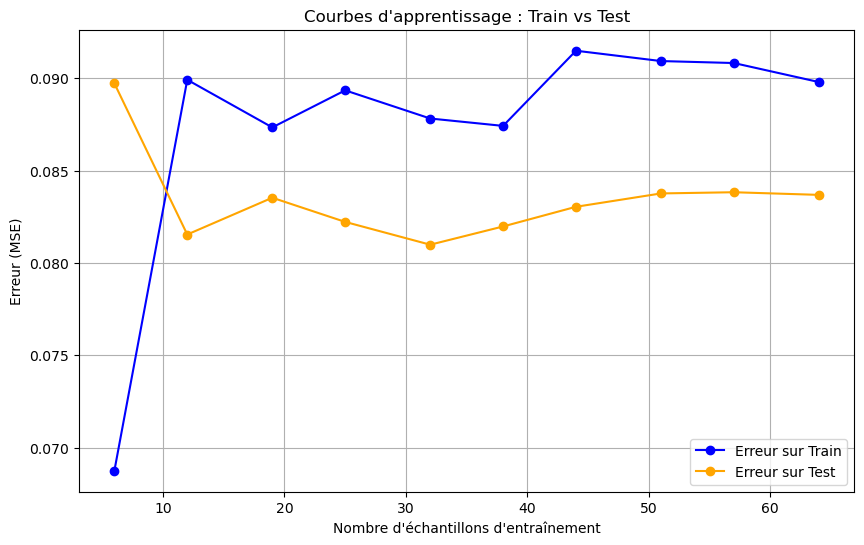

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

# Tracer les courbes d'apprentissage pour le modèle sélectionné
def plot_learning_curves(model, X, y, scoring='neg_mean_squared_error'):
    from sklearn.model_selection import ShuffleSplit

    # Définir une validation croisée
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # Calcul des courbes d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, scoring=scoring, train_sizes=np.linspace(0.1, 1.0, 10)
    )

    # Moyenne des erreurs (on prend l'opposé car sklearn retourne des scores négatifs pour MSE)
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)

    # Tracer les courbes
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Erreur sur Train")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange", label="Erreur sur Test")

    plt.title("Courbes d'apprentissage : Train vs Test")
    plt.xlabel("Nombre d'échantillons d'entraînement")
    plt.ylabel("Erreur (MSE)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# Appliquer à votre modèle
plot_learning_curves(best_model_row["Best Model"], X_train, y_train, scoring='neg_mean_squared_error')


## Coefficients et significativité avec le meilleur modèle


Coefficients et significativités :
    Feature  Coefficient P-Value
0  Feature1         -0.0     N/A
1  Feature2         -0.0     N/A
2  Feature3         -0.0     N/A
3  Feature4          0.0     N/A
4  Feature5         -0.0     N/A


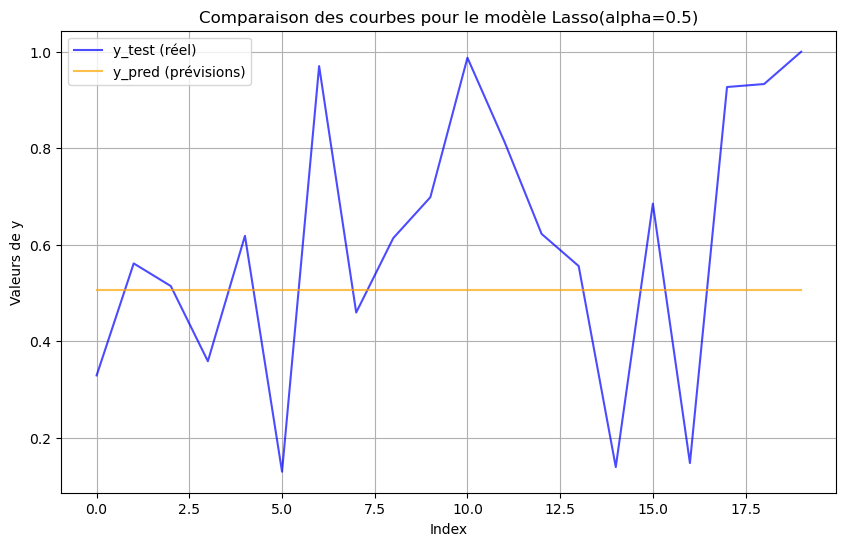


Le MSE final sur le jeu de test est : 0.08586156548817339


In [71]:
# Utilisation du meilleur modèle pour obtenir les coefficients et leur significativité
if best_model_row["Model"] == "LinearRegression()":
    best_model = LinearRegression()
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Calcul des coefficients et de leur significativité avec statsmodels
    X_train_sm = sm.add_constant(X_train)  # Ajout d'une constante pour le biais
    ols_model = sm.OLS(y_train, X_train_sm).fit()
    coefficients = pd.DataFrame({
        "Feature": ["Intercept"] + list(X_train.columns),
        "Coefficient": ols_model.params,
        "P-Value": ols_model.pvalues
    })

else:
    best_model = best_model_row["Model"]  # Évaluation du modèle (Ridge, Lasso, ElasticNet)
    best_model.set_params(**best_model_row["Best Parameters"])
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Extraction des coefficients pour les modèles Ridge, Lasso, et ElasticNet
    coefficients = pd.DataFrame({
        "Feature": list(X_train.columns),
        "Coefficient": best_model.coef_
    })
    coefficients["P-Value"] = "N/A"  # Les modèles régularisés n'ont pas de significativité statistique

# Affichage des coefficients et de leurs significativités
print("\nCoefficients et significativités :")
print(coefficients)

# Création d'un graphique comparant y_test et y_pred
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="y_test (réel)", color="blue", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="y_pred (prévisions)", color="orange", alpha=0.7)
plt.title(f"Comparaison des courbes pour le modèle {best_model_row['Model']}")
plt.xlabel("Index")
plt.ylabel("Valeurs de y")
plt.legend()
plt.grid(True)
plt.show()

# Calcul des performances finales
final_mse = mean_squared_error(y_test, y_pred)
print(f"\nLe MSE final sur le jeu de test est : {final_mse}")
